In [1]:
import pandas as pd
from database.market import Market
from database.strategy import Strategy
from database.sec import SEC
from modeler.modeler import Modeler as m
from datetime import datetime, timedelta, timezone
import numpy as np
import math
from tqdm import tqdm
import pickle
from sklearn.preprocessing import OneHotEncoder
from processor.processor import Processor as p
import statistics
import matplotlib.pyplot as plt

In [2]:
sec = SEC()
market = Market()

In [3]:
market.connect()
sp5 = market.retrieve("sp500")
market.disconnect()

In [6]:
ticker = "MSFT"
cik = int(sp5[sp5["Symbol"]==ticker]["CIK"].item())

In [6]:
sec.connect()
google_finance = sec.retrieve_filing_data(cik)
sec.disconnect()

In [4]:
market.connect()
prices = market.retrieve_ticker_prices("prices",ticker)
market.disconnect()

NameError: name 'ticker' is not defined

In [5]:
prices = p.column_date_processing(prices)
prices["year"] = [x.year for x in prices["date"]]
prices["quarter"] = [x.quarter for x in prices["date"]]

NameError: name 'prices' is not defined

In [9]:
google_finance["date"] = [datetime(int(str(x)[:4]),int(str(x)[4:6]),int(str(x)[6:])) for x in google_finance["filed"]]
google_finance["year"] = [x.year for x in google_finance["date"]]
google_finance["quarter"] = [x.quarter for x in google_finance["date"]]

In [11]:
quarterlies = prices.groupby(["year","quarter"]).mean()

In [12]:
study = quarterlies.merge(google_finance, on=["year","quarter"], how="left")

In [13]:
correlations = study.corr()
correlations.reset_index()

,index,year,quarter,close,high,low,open,volume,adjclose,adjhigh,...,FiniteLivedIntangibleAssetsAmortizationExpenseAfterYearFour,LesseeOperatingLeaseLiabilityPaymentsDueAfterYearFour,LongTermDebtMaturitiesRepaymentsOfPrincipalAfterYearFour,OtherReceivablesGrossCurrent,PremiumOnDebtExchange1,ContractWithCustomerLiabilityRevenueRecognizedIncludingAdditions,BusinessCombinationRecognizedIdentifiableAssetsAcquiredAndLiabilitiesAssumedIntangibles,PaymentsOfDebtRestructuringCosts,DeferredTaxAssetsAmortization,DeferredTaxLiabilitiesDepreciation
0,year,1.000000,-0.006673,0.248782,0.246085,0.251677,0.249058,0.234732,0.679768,0.679275,...,0.358682,0.946603,-0.315205,-0.231327,0.535471,NaN,NaN,NaN,NaN,NaN
1,quarter,-0.006673,1.000000,0.002476,0.001707,0.003192,0.002337,-0.041393,0.007472,0.006784,...,-0.349643,-0.353604,-0.578237,0.909904,0.409632,-0.134081,NaN,1.0,NaN,NaN
2,close,0.248782,0.002476,1.000000,0.999981,0.999985,0.999995,-0.520756,0.839463,0.839718,...,-0.017040,0.691908,-0.942323,0.602745,0.943433,-0.180333,NaN,1.0,NaN,NaN
3,high,0.246085,0.001707,0.999981,1.000000,0.999936,0.999984,-0.520818,0.838005,0.838280,...,-0.024486,0.688839,-0.944153,0.605469,0.942362,-0.188110,NaN,1.0,NaN,NaN
4,low,0.251677,0.003192,0.999985,0.999936,1.000000,0.999980,-0.520027,0.841171,0.841410,...,-0.011520,0.694505,-0.940815,0.599420,0.943454,-0.171404,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,ContractWithCustomerLiabilityRevenueRecognized...,NaN,-0.134081,-0.180333,-0.188110,-0.171404,-0.177613,-0.614965,-0.180439,-0.188072,...,0.900678,0.226362,0.811421,-0.438246,-0.245397,1.000000,NaN,1.0,NaN,NaN
688,BusinessCombinationRecognizedIdentifiableAsset...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
689,PaymentsOfDebtRestructuringCosts,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,...,NaN,NaN,NaN,1.000000,-1.000000,1.000000,NaN,1.0,NaN,NaN
690,DeferredTaxAssetsAmortization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
cleaned_columns = []
for col in study.columns:
    if len([x for x in study[col].isna() if not x]) > study.index.size - study.index.size * 0.60:
        cleaned_columns.append(col)

In [15]:
cleaned_study = study[cleaned_columns].fillna(method="ffill")

In [16]:
correlations = cleaned_study.corr()
correlations = correlations.reset_index()

In [17]:
relevant_columns = [x for x in cleaned_study.columns if x not in ['accepted', 'former', 'adsh', 'afs', 'baph', 'bas1', 'cityba', 'cityma', 'countryba', 'countryinc', 'countryma', 'date', 'form', 'fp', 'instance', 'mas1', 'name', 'stprba', 'stprinc', 'stprma', 'zipba', 'zipma']]
great = correlations.melt(id_vars=["index"],value_vars=relevant_columns)
great["abs"] = [abs(x) for x in great["value"]]
great[great["index"]=="adjclose"].sort_values("abs",ascending=False).head(50)

,index,variable,value,abs
637,adjclose,adjclose,1.000000,1.000000
907,adjclose,adjopen,0.999997,0.999997
817,adjclose,adjlow,0.999994,0.999994
727,adjclose,adjhigh,0.999992,0.999992
5137,adjclose,PropertyPlantAndEquipmentNet,0.984718,0.984718
1537,adjclose,AccumulatedDepreciationDepletionAndAmortizatio...,0.969744,0.969744
4237,adjclose,OtherAssetsCurrent,0.964982,0.964982
4327,adjclose,OtherAssetsNoncurrent,0.960582,0.960582
1267,adjclose,AccountsPayableCurrent,0.957300,0.957300
6757,adjclose,FiniteLivedIntangibleAssetsAccumulatedAmortiza...,0.956279,0.956279


In [7]:
sec.connect()
misc_columns =  ['accepted', 'former', 'adsh', 'afs', 'baph', 'bas1', 'cityba'
                 , 'cityma', 'countryba', 'countryinc', 'countryma','form', 'fp', 'instance', 'mas1'
                 , 'name', 'stprba', 'stprinc', 'stprma', 'zipba', 'zipma']
cleaned_financials = []
ticker = sp5["Symbol"].iloc[0]
cik = int(sp5[sp5["Symbol"]==ticker]["CIK"].item())
financials = sec.retrieve_filing_data(cik)
financials["date"] = [datetime(int(str(x)[:4]),int(str(x)[4:6]),int(str(x)[6:])) for x in financials["filed"]]
financials["year"] = [x.year for x in financials["date"]]
financials["quarter"] = [x.quarter for x in financials["date"]]
financials["ticker"] = ticker
financials = p.column_date_processing(financials)
cleaned_columns = []
for col in financials.columns:
    if col not in misc_columns:
        if len([x for x in financials[col].isna() if not x]) > financials.index.size - financials.index.size * 0.60:
            cleaned_columns.append(col)
cleaned_financials.append(financials[cleaned_columns])

In [8]:
cleaned_columns

['accountspayablecurrent',
 'accountsreceivablenetcurrent',
 'accruedincometaxescurrent',
 'accumulateddepreciationdepletionandamortizationpropertyplantandequipment',
 'accumulatedothercomprehensiveincomelossnetoftax',
 'additionalpaidincapitalcommonstock',
 'assets',
 'assetscurrent',
 'cashandcashequivalentsatcarryingvalue',
 'cashandcashequivalentsperiodincreasedecrease',
 'commonstockdividendspersharecashpaid',
 'commonstockparorstatedvaluepershare',
 'commonstocksharesissued',
 'commonstockvalue',
 'costofrevenue',
 'costsandexpenses',
 'debtcurrent',
 'deferredincometaxexpensebenefit',
 'definedbenefitplanassetsforplanbenefitsnoncurrent',
 'earningspersharebasic',
 'earningspersharediluted',
 'effectofexchangerateoncashandcashequivalents',
 'employeerelatedliabilitiescurrent',
 'entitycommonstocksharesoutstanding',
 'excesstaxbenefitfromsharebasedcompensationfinancingactivities',
 'excesstaxbenefitfromsharebasedcompensationoperatingactivities',
 'goodwill',
 'incometaxexpensebene

In [9]:
for ticker in sp5["Symbol"]:
    try:
        cik = int(sp5[sp5["Symbol"]==ticker]["CIK"].item())
        financials = sec.retrieve_filing_data(cik)
        financials["date"] = [datetime(int(str(x)[:4]),int(str(x)[4:6]),int(str(x)[6:])) for x in financials["filed"]]
        financials["year"] = [x.year for x in financials["date"]]
        financials["quarter"] = [x.quarter for x in financials["date"]]
        financials["ticker"] = ticker
        financials = p.column_date_processing(financials)
        firm_cleaned_columns = []
        for col in financials.columns:
            if col not in misc_columns:
                if len([x for x in financials[col].isna() if not x]) > financials.index.size - financials.index.size * 0.60:
                    firm_cleaned_columns.append(col)
        cleaned_columns = [x for x in firm_cleaned_columns if x in cleaned_columns]
        print(ticker,len(cleaned_columns))
        cleaned_financials.append(financials[cleaned_columns])
    except Exception as e:
        print(str(e))
        continue
sec.disconnect()

MMM 179
ABT 85
ABBV 63
ABMD 53
ACN 46
ATVI 43
ADBE 42
AMD 42
AAP 42
AES 40
AFL 33
A 32
APD 29
AKAM 29
ALK 29
ALB 28
ARE 26
ALGN 26
ALLE 26
LNT 25
ALL 23
GOOGL 21
GOOG 21
MO 21
AMZN 21
AMCR 21
AEE 21
AAL 21
AEP 21
AXP 21
AIG 21
AMT 21
AWK 21
AMP 20
ABC 20
AME 20
AMGN 20
APH 20
ADI 20
ANSS 20
ANTM 20
AON 20
AOS 20
APA 20
AAPL 20
AMAT 20
APTV 20
ADM 19
ANET 19
AJG 19
AIZ 19
T 19
ATO 19
ADSK 19
ADP 19
AZO 19
AVB 19
AVY 19
BKR 19
BLL 19
BAC 19
BBWI 19
BAX 19
BDX 19
BRK.B 18
BBY 18
BIO 18
TECH 18
BIIB 18
BLK 18
BK 18
BA 18
BKNG 18
BWA 18
BXP 18
BSX 18
BMY 18
AVGO 18
BR 18
BRO 17
BF.B 17
CHRW 17
CDNS 17
CZR 17
CPB 17
COF 17
CAH 17
KMX 17
CCL 17
CARR 17
CTLT 17
CAT 17
CBOE 17
CBRE 17
CDW 17
CE 17
CNC 17
CNP 17
CDAY 17
CERN 17
CF 17
CRL 17
SCHW 17
CHTR 17
CVX 17
CMG 17
CB 17
CHD 17
CI 17
CINF 17
CTAS 17
CSCO 17
C 17
CFG 17
CTXS 17
CLX 17
CME 17
CMS 17
KO 17
CTSH 17
CL 17
CMCSA 17
CMA 17
CAG 17
COP 17
ED 17
STZ 17
COO 17
CPRT 17
GLW 17
CTVA 17
COST 17
CTRA 17
CCI 17
CSX 17
CMI 17
CVS 17
DHI 17
D

In [10]:
market.connect()
financials = market.retrieve("unified_financials")
prices = market.retrieve("prices")
market.disconnect()

In [11]:
financials = p.column_date_processing(financials)
financials["quarter"] = [x.quarter for x in financials["date"]]
financials["year"] =[x.year for x in financials["date"]]

In [12]:
prices = p.column_date_processing(prices)
prices["quarter"] = [x.quarter for x in prices["date"]]
prices["year"] =[x.year for x in prices["date"]]

In [13]:
quarterlies = prices.groupby(["year","quarter","ticker"]).mean()

In [14]:
quarterlies = quarterlies.reset_index()[["year",'quarter','ticker',"adjclose"]]

In [15]:
data = financials.merge(quarterlies,on=["year","quarter","ticker"],how="left").groupby(["year","quarter","ticker"]).mean().reset_index()

In [16]:
data

,year,quarter,ticker,assets,liabilitiesandstockholdersequity,netcashprovidedbyusedinfinancingactivities,netcashprovidedbyusedininvestingactivities,adjclose
0,2009,2,ADBE,5.942672e+09,5.942672e+09,-3.647485e+08,-4.482250e+07,26.689683
1,2009,2,ADSK,2.345100e+09,2.345100e+09,-1.029500e+08,-2.700000e+07,19.878571
2,2009,2,CSX,2.642750e+10,2.642750e+10,4.335000e+08,-2.305000e+08,2.735117
3,2009,2,CVX,1.602955e+11,1.602955e+11,-7.520000e+08,-4.203500e+09,40.827585
4,2009,2,FCX,2.353050e+10,2.353050e+10,3.115000e+08,-5.015000e+08,18.611460
...,...,...,...,...,...,...,...,...
21199,2021,4,YUM,6.135500e+09,6.135500e+09,-4.285000e+08,-1.960000e+08,127.063936
21200,2021,4,ZBH,2.421315e+10,2.421315e+10,-3.928500e+08,-3.276500e+08,NaN
21201,2021,4,ZBRA,5.620000e+09,5.620000e+09,-1.100000e+08,-4.960000e+08,NaN
21202,2021,4,ZION,8.489250e+10,8.489250e+10,7.334000e+09,-7.877000e+09,NaN


In [17]:
data = data.dropna()
new_prices = []
prediction_gap = 1
for ticker in data["ticker"].unique():
    try:
        ticker_data = data[data["ticker"]==ticker][["year","quarter","ticker","adjclose"]]
        ticker_prices = ticker_data.copy()
        ticker_prices["year"] = ticker_prices["year"] - prediction_gap
        new_prices.append(ticker_prices)
    except Exception as e:
        print(ticker,str(e))

In [18]:
pd.concat(new_prices)

,year,quarter,ticker,adjclose
0,2008,2,ADBE,26.689683
252,2008,4,ADBE,35.467344
518,2009,1,ADBE,34.661148
786,2009,2,ADBE,33.062143
1053,2009,3,ADBE,28.654959
...,...,...,...,...
21132,2020,4,TECH,509.550000
21150,2020,4,TWTR,51.948281
21175,2020,4,VTRS,13.289431
21179,2020,4,WBA,48.209455


In [19]:
model_data = data.merge(pd.concat(new_prices).rename(columns={"adjclose":"y"}),on=["year","quarter","ticker"])

In [20]:
data

,year,quarter,ticker,assets,liabilitiesandstockholdersequity,netcashprovidedbyusedinfinancingactivities,netcashprovidedbyusedininvestingactivities,adjclose
0,2009,2,ADBE,5.942672e+09,5.942672e+09,-3.647485e+08,-4.482250e+07,26.689683
1,2009,2,ADSK,2.345100e+09,2.345100e+09,-1.029500e+08,-2.700000e+07,19.878571
2,2009,2,CSX,2.642750e+10,2.642750e+10,4.335000e+08,-2.305000e+08,2.735117
3,2009,2,CVX,1.602955e+11,1.602955e+11,-7.520000e+08,-4.203500e+09,40.827585
4,2009,2,FCX,2.353050e+10,2.353050e+10,3.115000e+08,-5.015000e+08,18.611460
...,...,...,...,...,...,...,...,...
21195,2021,4,XLNX,5.757381e+09,5.757381e+09,1.820125e+08,-8.657385e+08,196.244093
21196,2021,4,XOM,3.347190e+11,3.347190e+11,-5.948000e+09,-1.164100e+10,62.125348
21197,2021,4,XRAY,9.315000e+09,9.315000e+09,1.235000e+08,-1.620000e+08,54.993583
21198,2021,4,XYL,8.450500e+09,8.450500e+09,-1.280000e+08,-2.195000e+08,124.175992


In [21]:
training_data = model_data[(model_data["year"] < 2016)]
prediction_data = model_data[model_data["year"] >= 2020]
factors = ["assets"
           ,"liabilitiesandstockholdersequity"
           ,"netcashprovidedbyusedinfinancingactivities"
           ,"netcashprovidedbyusedininvestingactivities"
           ,"adjclose"]
refined_data = {"X":training_data[factors],"y":training_data[["y"]]}
model = m.regression(refined_data)

In [38]:
sim = prediction_data
for row in model.iterrows():
    api = row[1]["api"]
    score = row[1]["score"]
    current_model = row[1]["model"]
    predictions = current_model.predict(sim[factors])
    sim[f"{api}_prediction"] = predictions
    sim[f"{api}_score"] = score
    sim["prediction_gap"] = prediction_gap

In [40]:
sim["year"] = sim["year"] + prediction_gap

In [41]:
sim

,year,quarter,ticker,assets,liabilitiesandstockholdersequity,netcashprovidedbyusedinfinancingactivities,netcashprovidedbyusedininvestingactivities,adjclose,y,skl_prediction,skl_score,prediction_gap,xgb_prediction,xgb_score,cat_prediction,cat_score
16554,2021,1,A,9.476500e+09,9.476500e+09,-9.150000e+07,-1.625000e+08,79.372058,123.091553,91.727399,0.918647,1,91.724503,0.909873,92.050970,0.938871
16555,2021,1,AAL,6.028750e+10,6.028750e+10,-1.461667e+09,-2.617333e+09,22.755579,19.287377,26.448930,0.918647,1,26.453215,0.909873,25.341035,0.938871
16556,2021,1,AAP,1.014459e+10,1.014459e+10,-3.869800e+08,-2.778017e+08,126.561798,165.193098,145.590544,0.918647,1,145.588089,0.909873,157.374063,0.938871
16557,2021,1,AAPL,3.395670e+11,3.395670e+11,-1.954150e+10,-3.912000e+09,72.563265,127.688097,80.411545,0.918647,1,80.431389,0.909873,77.433321,0.938871
16558,2021,1,ABC,3.959436e+10,3.959436e+10,-2.628855e+08,-9.497850e+07,85.482290,106.809976,98.622067,0.918647,1,98.621147,0.909873,100.076767,0.938871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18245,2021,4,XLNX,5.134632e+09,5.134632e+09,-1.359060e+08,-6.453780e+08,129.657998,196.244093,149.122749,0.918647,1,149.120743,0.909873,158.293605,0.938871
18246,2021,4,XOM,3.603200e+11,3.603200e+11,4.203000e+09,-1.698850e+10,34.986025,62.125348,38.508019,0.918647,1,38.561630,0.909873,40.257267,0.938871
18247,2021,4,XRAY,8.749400e+09,8.749400e+09,6.700000e+07,-2.205000e+07,48.977025,54.993583,57.039462,0.918647,1,57.036140,0.909873,56.444812,0.938871
18248,2021,4,XYL,8.079000e+09,8.079000e+09,2.255000e+08,-2.555000e+08,93.005398,124.175992,107.331468,0.918647,1,107.328857,0.909873,110.439644,0.938871


In [ ]:
# model["model"] = [pickle.dumps(x) for x in model["model"]]# model["model"] = [pickle.dumps(x) for x in model["model"]]
# model["prediction_gap"] = prediction_gap
# market.connect()
# market.store("general_financial_model",model)
# market.disconnect()

In [271]:
market.connect()
models = market.retrieve("general_financial_model")
market.disconnect()

In [273]:
models = models.fillna(1)
models = models[models["prediction_gap"]==1]
models["model"] = [pickle.loads(x) for x in models["model"]]

In [275]:
sim = data
for row in models.iterrows():
    api = row[1]["api"]
    score = row[1]["score"]
    current_model = row[1]["model"]
    predictions = current_model.predict(sim[factors])
    sim[f"{api}_prediction"] = predictions
    sim[f"{api}_score"] = score
    sim["prediction_gap"] = prediction_gap

In [276]:
sim

,year,quarter,ticker,assets,liabilitiesandstockholdersequity,netcashprovidedbyusedinfinancingactivities,netcashprovidedbyusedininvestingactivities,adjclose,skl_prediction,skl_score,prediction_gap,xgb_prediction,xgb_score,cat_prediction,cat_score
0,2009,2,ADBE,5.942672e+09,5.942672e+09,-3.647485e+08,-4.482250e+07,26.689683,30.993344,0.941094,3,30.981798,0.937964,35.829450,0.926324
1,2009,2,ADSK,2.345100e+09,2.345100e+09,-1.029500e+08,-2.700000e+07,19.878571,23.201849,0.941094,3,23.189579,0.937964,24.526366,0.926324
2,2009,2,CSX,2.642750e+10,2.642750e+10,4.335000e+08,-2.305000e+08,2.735117,3.363103,0.941094,3,3.357717,0.937964,7.118194,0.926324
3,2009,2,CVX,1.602955e+11,1.602955e+11,-7.520000e+08,-4.203500e+09,40.827585,46.385521,0.941094,3,46.432190,0.937964,44.932127,0.926324
4,2009,2,FCX,2.353050e+10,2.353050e+10,3.115000e+08,-5.015000e+08,18.611460,21.643043,0.941094,3,21.638401,0.937964,23.060397,0.926324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21195,2021,4,XLNX,5.757381e+09,5.757381e+09,1.820125e+08,-8.657385e+08,196.244093,225.946019,0.941094,3,225.937607,0.937964,235.757112,0.926324
21196,2021,4,XOM,3.347190e+11,3.347190e+11,-5.948000e+09,-1.164100e+10,62.125348,69.855804,0.941094,3,69.982643,0.937964,64.043893,0.926324
21197,2021,4,XRAY,9.315000e+09,9.315000e+09,1.235000e+08,-1.620000e+08,54.993583,63.529400,0.941094,3,63.519154,0.937964,62.088610,0.926324
21198,2021,4,XYL,8.450500e+09,8.450500e+09,-1.280000e+08,-2.195000e+08,124.175992,143.040847,0.941094,3,143.029892,0.937964,137.398393,0.926324


In [261]:
# market.connect()
# sim = market.retrieve("general_financial_statement_sim")
# market.disconnect()

In [262]:
# sim["prediction_gap"] = sim["prediction_gap"].fillna(1)

In [263]:
# sim = sim[sim["prediction_gap"]==1].drop(["average_prediction","average_score"],axis=1,errors="ignore")

In [42]:
sim["average_prediction"] = [statistics.mean([row[1][col] for col in sim.columns if "prediction" in col]) for row in sim.iterrows()]

In [43]:
sim["average_score"] = [statistics.mean([row[1][col] for col in sim.columns if "score" in col]) for row in sim.iterrows()]

In [32]:
sim["year"] = sim["year"] - 1

In [44]:
research_set = prices[["date","year","quarter","ticker","adjclose"]].merge(sim[["year","quarter","ticker","average_prediction","average_score"]],how="right")

In [45]:
research_set

,date,year,quarter,ticker,adjclose,average_prediction,average_score
0,2021-01-04,2021,1,A,118.158539,69.125718,0.922464
1,2021-01-05,2021,1,A,119.124603,69.125718,0.922464
2,2021-01-06,2021,1,A,122.391292,69.125718,0.922464
3,2021-01-07,2021,1,A,125.648022,69.125718,0.922464
4,2021-01-08,2021,1,A,126.544369,69.125718,0.922464
...,...,...,...,...,...,...,...
106796,2021-12-21,2021,4,YUM,133.370000,87.310892,0.922464
106797,2021-12-22,2021,4,YUM,134.630000,87.310892,0.922464
106798,2021-12-23,2021,4,YUM,135.340000,87.310892,0.922464
106799,2021-12-27,2021,4,YUM,138.010000,87.310892,0.922464


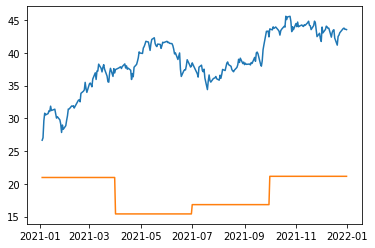

In [62]:
ticker = "FITB"
visualization_data = research_set[(research_set["ticker"]==ticker)].copy().sort_values("date")
plt.plot(visualization_data["date"],visualization_data["adjclose"])
plt.plot(visualization_data["date"],visualization_data["average_prediction"])

In [46]:
research_set["inflation"] = (research_set["adjclose"] - research_set["average_prediction"]) / research_set["average_prediction"]

In [47]:
inflation_report = research_set[(research_set["year"]==2021) & (research_set["quarter"]==4)].groupby(["year","quarter","ticker"]).mean().reset_index()

In [49]:
inflation_report.sort_values("inflation",ascending=False).head(50)

,year,quarter,ticker,adjclose,average_prediction,average_score,inflation
122,2021,4,DVN,40.979128,10.970853,0.922464,2.735273
154,2021,4,FTNT,329.049219,112.564262,0.922464,1.923212
49,2021,4,BBWI,70.919557,25.667924,0.922464,1.762964
259,2021,4,MRO,16.045897,6.005050,0.922464,1.672067
292,2021,4,OXY,31.373271,12.033216,0.922464,1.607222
143,2021,4,F,18.357412,7.181371,0.922464,1.556255
132,2021,4,EOG,88.096774,34.908271,0.922464,1.523665
201,2021,4,IT,321.542188,127.558645,0.922464,1.520740
20,2021,4,ALB,247.088953,98.094647,0.922464,1.518883
163,2021,4,GOOG,2890.578750,1164.330949,0.922464,1.482609
